In [26]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import seed
from numpy.random import rand
import pymc3 as pm
import arviz as az

## Data generation

### Manual way

In [27]:
seed(1)

In [28]:
def generate_dataset_manual(beta, n, std_dev):
    x = np.array(np.random.rand(n) * 100)
    e = np.random.randn(n) * std_dev
    y = x * beta + e

    return x, y


In [29]:
x_original, y = generate_dataset_manual(2, 100, 10)
y_real = 2 * x_original

In [30]:
x_centered = x_original - x_original.mean()

### Plot real model with observations

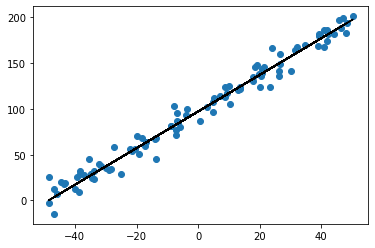

In [31]:
plt.scatter(x_centered, y)
plt.plot(x_centered, y_real, 'k')

In [32]:
def plot_data(x, y, y_real=None):
    _, ax = plt.subplots(1, 2, figsize=(11,5))
    ax[0].scatter(x, y)
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    if y_real is not None:
        ax[0].plot(x, y_real, 'k')

    az.plot_kde(y, ax=ax[1])
    ax[1].set_xlabel('y')
    plt.tight_layout()

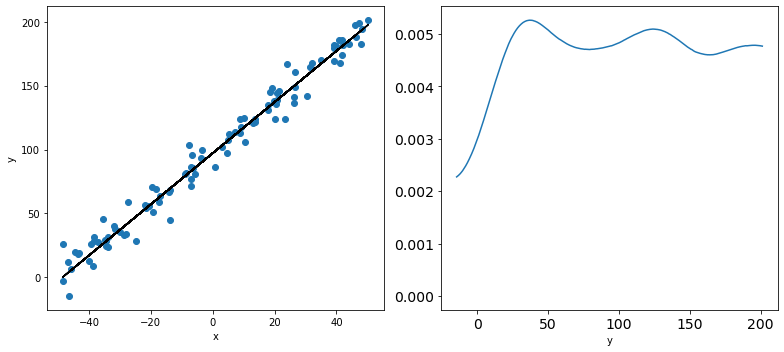

In [33]:
plot_data(x_centered, y, y_real)

In [34]:
import pandas as pd
df = pd.DataFrame(data={'x':x_centered.flatten(),'y':y})
# Another way to do the same without explicit column names
#df = pd.DataFrame([x.ravel(), y]).T
df.head(10)

,x,y
0,-6.885592,86.560750
1,23.444657,123.842887
2,-48.576355,-3.039165
3,-18.354535,68.746261
4,-33.912204,31.652126
5,-39.353933,26.087831
6,-29.961772,35.028761
7,-14.031720,67.104565
8,-8.911045,81.219109
9,5.293881,111.863863


## Model

In [35]:
def model_data(x, y):
    with pm.Model() as linreg_model:
        alpha = pm.Normal('alpha', mu=0, sd=10)
        beta = pm.Normal('beta', mu=40, sd=10)
        error = pm.HalfCauchy('error', 5)
        
        y_mu = pm.Deterministic('y_mu', beta * x + alpha)
        y_pred = pm.Normal('y_pred', mu=y_mu, sd=error, observed=y)

        trace = pm.sample(2000, tune=1000)

        return trace

def plot_trace(trace):
    az.plot_trace(trace, var_names=['alpha', 'beta', 'error', 'y_mu'])

def get_summary(trace):
    return az.summary(trace, var_names=['alpha', 'beta', 'error'])

In [36]:
trace_centered = model_data(x_centered, y)

<ipython-input-35-ff760202139c>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8855596036836896, but should be close to 0.8. Try to increase the number of tuning steps.


/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


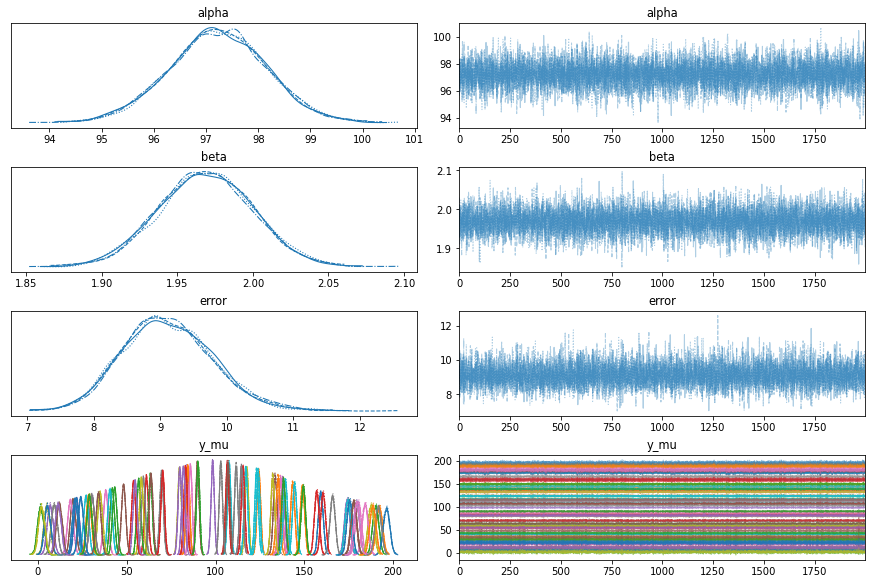

In [37]:
plot_trace(trace_centered)

In [38]:
summary = get_summary(trace_centered)
summary

/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,97.226,0.936,95.422,98.956,0.010,0.007,9351.0,5428.0,1.0
beta,1.969,0.031,1.910,2.027,0.000,0.000,9582.0,5735.0,1.0
error,9.113,0.670,7.909,10.386,0.007,0.005,9952.0,6038.0,1.0


### Final model with centered x

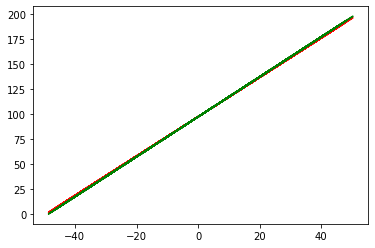

In [39]:
y_point_estimate = summary['mean']['alpha'] + summary['mean']['beta'] * x_centered

plt.plot(x_centered, y_point_estimate, 'r')
plt.plot(x_centered, y_real, 'g')

### Change x back to original scale (non-centered)

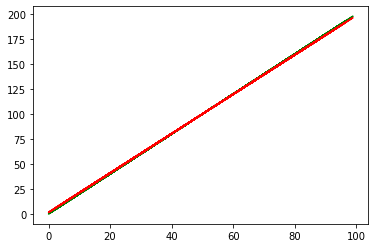

In [40]:
y_point_estimate = summary['mean']['alpha'] + summary['mean']['beta'] * (x_original - x_original.mean())
plt.plot(x_original, y_real, 'g')
plt.plot(x_original, y_point_estimate, 'r')

## Model with non-centered data

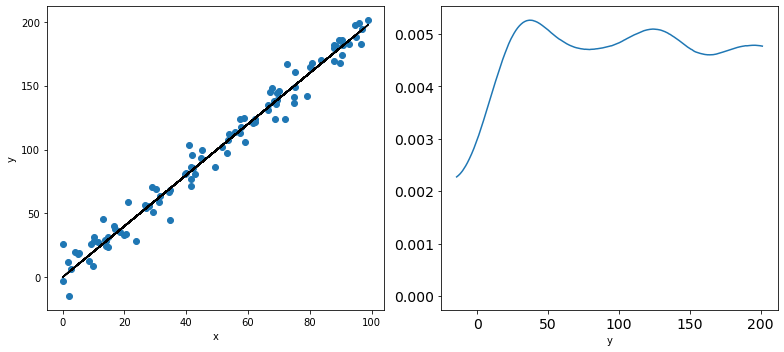

In [41]:
plot_data(x_original, y, y_real)

In [42]:
trace_non_centered = model_data(x_original, y)

<ipython-input-35-ff760202139c>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.9425654183649959, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8832779134870259, but should be close to 0.8. Try to increase the number of tuning steps.


/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


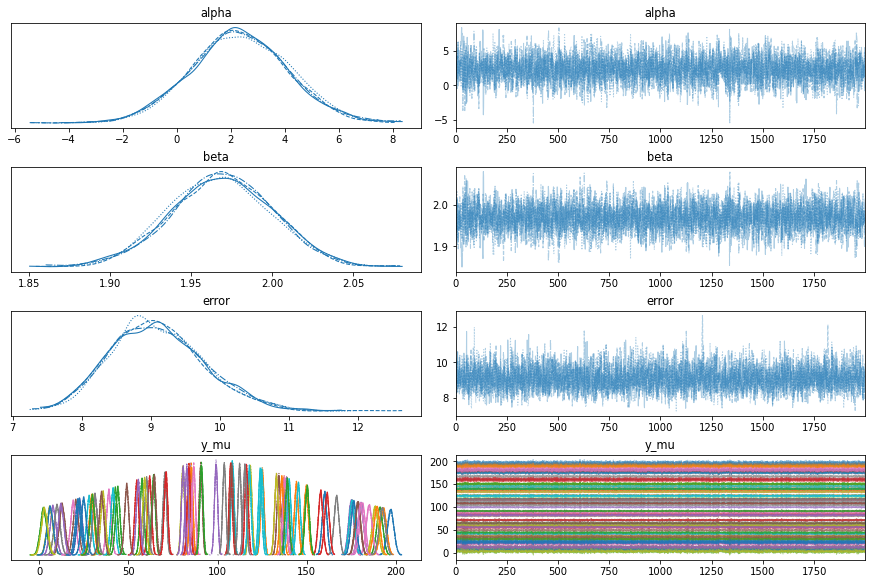

In [43]:
plot_trace(trace_non_centered)

#### Data generation with Scikit-learn

In [44]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

bias = 0
x, y, coef = datasets.make_regression(n_samples=100,
                                      n_features=1,
                                      n_informative=1,
                                      noise=10,
                                      coef=True, # True coefficient used to generated the data
                                      random_state=0)

print('Coefficient: {}'.format(coef))            
y_real = coef * x + bias

Coefficient: 42.38550485581797


In [45]:
# Scale X (years of experience) to 0..10 range
x = np.interp(x, (x.min(), x.max()), (0, 10))

# Scale y (salary) to 30000..100000 range
y = np.interp(y, (y.min(), y.max()), (30000, 100000))
#pd.DataFrame(data = {'x': x, 'y': y }).sort_values('x')
df = pd.DataFrame({'experience': x.flatten(), 'salary': y})
print(df.sort_values('experience').head(10))

    experience        salary
64    0.000000  30000.000000
63    1.186448  38641.676787
57    1.714184  35991.000664
42    1.755680  44587.247394
75    1.913416  42410.147660
98    1.947215  50452.359955
12    2.108231  42536.922703
65    2.278006  47656.501996
51    2.349226  44038.300715
39    2.695964  52723.267005


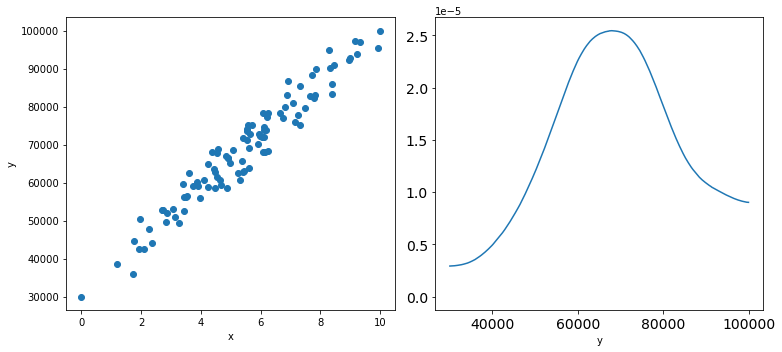

In [46]:
plot_data(x.flatten(), y)

In [47]:
# Sampling fails without standardization, the scales of x and y are too different,
# forcing zero values
x = x.flatten()
x_standardized = (x - x.mean()) / x.std()
y_standardized = (y - y.mean()) / y.std()

with pm.Model() as m:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=42, sd=1)
    error = pm.HalfCauchy('error', 5)
    
    y_mu = pm.Deterministic('y_mu', beta * x_standardized + alpha)
    y_pred = pm.Normal('y_pred', mu=y_mu, sd=error, observed=y_standardized)

    trace = pm.sample(5000, tune=1000, init="adapt_diag")

<ipython-input-47-874c7be1387d>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, tune=1000, init="adapt_diag")
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


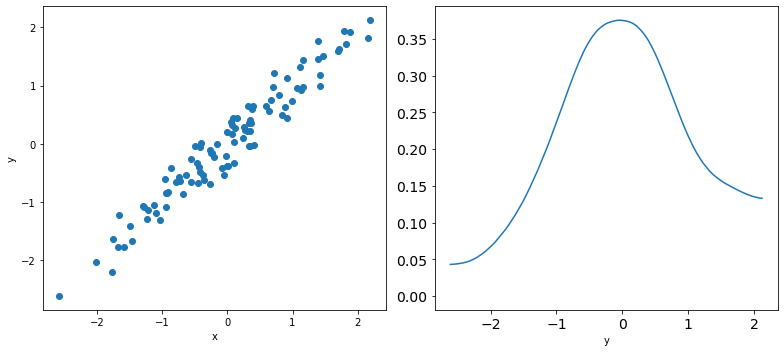

In [48]:
plot_data(x_standardized, y_standardized)

/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


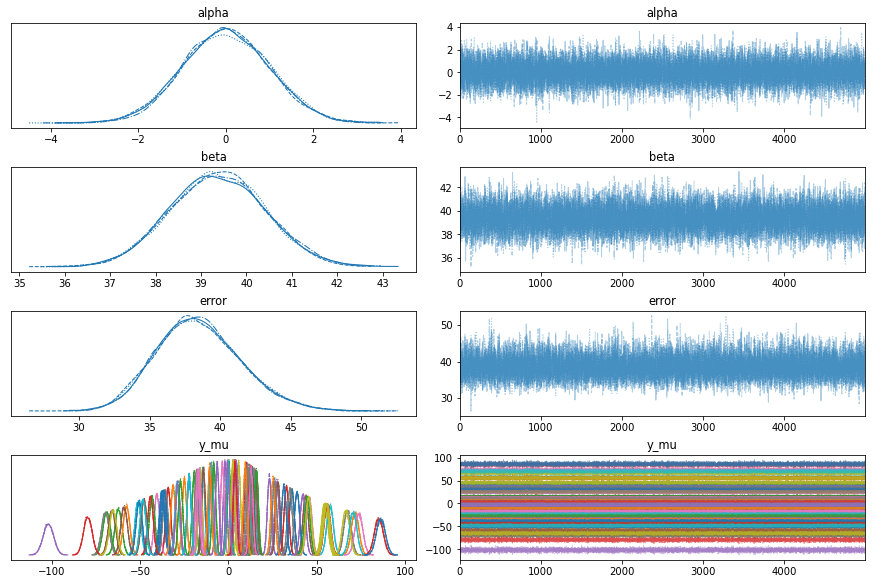

In [49]:
plot_trace(trace)

In [50]:
get_summary(trace)

/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.009,0.987,-1.801,1.886,0.006,0.007,26228.0,13453.0,1.0
beta,39.371,1.047,37.489,41.395,0.007,0.005,21960.0,15703.0,1.0
error,38.488,2.972,32.952,44.029,0.020,0.014,21286.0,13700.0,1.0
